# Project 1. Navigation

In this project, I trained an agent to collect yellow bananas and avoid blue bananas using Deep Q Network algorithms.

<br>

## Problem Definition

### Environment
The given environment is a flat 3d space where yellow and blue bananas drop from above randomly.
![](assets/env.png)

### State
The agent understands the given environment through 37 numbers that represent the agent's velocity and the relative locations of objects that are ahead of it.

### Action
The agent can move forward, backward, to the left or the right.

### Reward
The agent gets +1 for getting a single yellow banana and -1 for a blue one.

### Completion Target
The agent is considered to be trained successfully when it gets an average score of +13 over 100 episodes in a row.

## Algorithms

To train a successful agent I used the following techniques.

### DQN
Deep Q Network is a combination of Q learning and non-linear function approximator powered by deep neural network. To avoid unstable training and divergence of using non-linear function approximator, DQN utilizes fixed Q target and experience replay buffer. DQN uses two neural network that have an identical network structure. A local network is used to predict the target Q value which, in turn, gets evaluated by a target network. Fixing the parameters of the target network and update them less frequently than the local network enables stable convergence of DQN agent. Experience Replay Buffer, inspired by how we remind of memories of the past when learning something, stores agent's trajectories and samples them for training the two networks. Thanks to the replay buffer the training becomes much easier and more effective by breaking correlations between adjacent trajectories.


### DDQN
In DQN we use a target network for setting a training target. Because this target is generated via function approximation, its quality can be questionable especially in the early training. To enhance the robustness of the training target, Double DQN decouples selection from evaluation 
Double DQN enhances robustness of DQN by decoupling selection and evaluation. The agent chooses a greedy action using the local network (selection) before estimating its value through the target network. 

### Prioritized Experience Replay
How Experience Replay Buffer in DQN generates random trajectory follows a uniform random distribution. Prioritized Experience Replay is devised to pay more attention to memories that are rarer and of greater lessons. Samples drawn from the buffer are fed into the DQN algorithm before getting priorities based on the magnitude of TD error $delta$. There are two additional hyperparameters $\alpha$ and $\beta$ for controlling how much Prioritized Experience Replay affects the sampling distribution and network parameter updates.

### Dueling Network
Dueling Network comes in handy especially when choosing an action is not always meaningful for given states. It utilises two streams so that it can separate state value estimations from action value estimations internally.

## Experiment Design

I have decided to tune the following hyper-parameters:
- is_duelingNetwork: whether to use a simple DNN or a dueling network
- use_per: whether to use Prioritized Experience Replay or Experience Replay Buffer
- use_ddqn: whether to use DQN or Double DQN for learning

The other hyper-parameters are fixed as follows:
- network_layers: state_size - 64 - 64 - action_size (simple DNN)
- buffer_size: 100000
- batch_Size: 64,
- gamma: 0.99
- tau: 1e-3 (for soft update)
- lr: 0.0005
- update_every: 4 (for the target network)
- n_episodes: 2000
- eps_start: 1.0 (epsilon for exploration)
- eps_end: 0.01 (minimum epsilon value)
- eps_decay: 0.995

## Experiment Result
I ran the following experiments to find the best performing agent
- dqn_netA_er (DQN + Experience Replay)
- dqn_netA_per (DQN + Prioritized Experience Replay)
- ddqn_netA_er (DDQN + Experience Replay)
- ddqn_dn_netA_er (DDQN + DuelingNetwork + Experience Replay)
- ddqn_dn_netA_per (DDQN + DuelingNetwork + Prioritized Experience Replay)

In [6]:
import glob
import pickle
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
score_paths = glob.glob("experiments/*/*.pkl")

In [8]:
exp_dict = {}
for path in score_paths:
    exp_name = path.split("/")[1]
    with open(path, "rb") as f:
        score_data = pickle.load(f)
    exp_dict[exp_name] = score_data

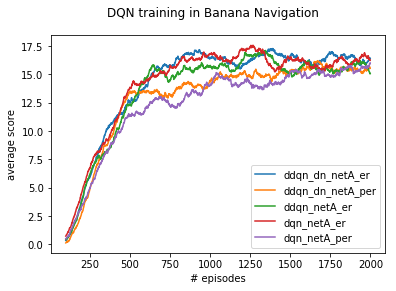

In [13]:
fig, ax = plt.subplots()
score_df = pd.DataFrame(exp_dict)
score_df.rolling(100).mean().dropna().plot(ax=ax)
ax.set_xlabel("# episodes")
ax.set_ylabel("average score")
fig.suptitle("DQN training in Banana Navigation")
plt.show()

In [15]:
score_df.max()

ddqn_dn_netA_er     27.0
ddqn_dn_netA_per    25.0
ddqn_netA_er        27.0
dqn_netA_er         27.0
dqn_netA_per        26.0
dtype: float64

## Experiment Evaluation

All of the 5 experiments successfully solved the task by acquiring scores of 25.0 to 27.0 which is much higher than the project guideline 13.0. Much to my disappointment Prioritized Experience Replay failed to enhance the training performance. The agents with basic Experience Replay reached higher scores faster than the others with PER. Plus the gap between DDQN and DQN does not appear to be noticable. I presume that the complexity of the problem environment was easy enough for the vanilla DQN to solve. DDQN might show some more drastic performance enhancement when solving pixel2action problems. 

## Ideas for Future Work
- Prioritized Experience Replay
I'm not 100% sure about my implementation of Prioritized Experience Replay. My implementation might have some glitches that led to the slightly unsatisfying training performance compared to Experience Replay. I might try implementing PER using sumtree.

- RAINBOW and distributed learning
In the course material I read some information about distributed learning and RAINBOW that combines all of the techniques since the birth of DQN. I wonder how much of an improvement distributed learning would achieve.

- pixel2action
A simple DNN would not be complex enough to process raw pixel information in the given 3d environment. Using CNN to train an agent would be an interesting project to spend the winter.

## Let the agent roll
I picked DDQN + Experience Replay as my best agent to play Banana Navigation task. Here's how it plays. 

In [17]:
import os
from collections import Counter

import numpy as np
import torch
from unityagents import UnityEnvironment

from model import net, agent
import utils

In [18]:
params_dir = "ddqn_netA_er"
params = utils.Params(params_dir)
params.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params.model_pt = os.path.join("experiments/{}/model.pt".format(params_dir))

In [19]:
model = net.dqn_network(params)
ckpt = utils.load_checkpoint(params.model_pt, model)
model.eval()

dqn_network(
  (network_front): Sequential(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (network_back): ModuleList(
    (0): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [20]:
trained_agent = agent.DDQNAgent(params, model, model, None)

In [21]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [22]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
scores = []                                          # initialize the score
while True:
    action = trained_agent.act(state)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    scores.append(reward)                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("\n")
print("Score: {}".format(np.sum(scores)))

Reward: 0.0

Score: 15.0


In [23]:
Counter(scores)

Counter({0.0: 285, 1.0: 15})

![](assets/trained_agent.gif)

### Random Agent

In [25]:
env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations[0]            
scores = []
action_size= 4
while True:
    action = np.random.randint(action_size)        
    env_info = env.step(action)[brain_name]        
    next_state = env_info.vector_observations[0]   
    reward = env_info.rewards[0]                   
    done = env_info.local_done[0]                  
    scores.append(reward)                          
    state = next_state                             
    if done:                                       
        break
    
print("\n")
print("Score: {}".format(np.sum(scores)))



Score: 1.0


In [26]:
Counter(scores)

Counter({1.0: 2, 0.0: 297, -1.0: 1})

![](assets/random_agent.gif)